In [23]:
import os
import gzip
import requests
import numpy as np
from tqdm import tqdm

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


data_dir = "./data"
device = jax.devices('cpu')[0]

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [24]:
def z_meas_to_binary(line: str) -> np.ndarray:
    binary_array = [c == "Z" for c in line.strip()]
    return np.array(binary_array, dtype=np.float32).reshape(-1)

data_file = os.path.join(data_dir, "w_vanilla_20_20000.txt")

with open(data_file) as f:
    data = np.stack([z_meas_to_binary(l) for l in f])

print(f"Loaded {len(data)} samples, each of length {data.shape[1]} into numpy array of type {data.dtype}.")

num_train_samples = 1000
rng = PRNGKey(0)

data_subset = jax.random.choice(rng, data, (num_train_samples,), replace=False)

print(f"Subset shape: {data_subset.shape}")

Loaded 20000 samples, each of length 20 into numpy array of type float32.
Subset shape: (1000, 20)


In [25]:
# relative frequency of up-spin
rel_freq = data_subset.mean(axis=0)
rel_freq

Array([0.058, 0.054, 0.034, 0.038, 0.039, 0.051, 0.045, 0.04 , 0.054,
       0.056, 0.05 , 0.062, 0.06 , 0.053, 0.062, 0.051, 0.045, 0.051,
       0.046, 0.051], dtype=float32)

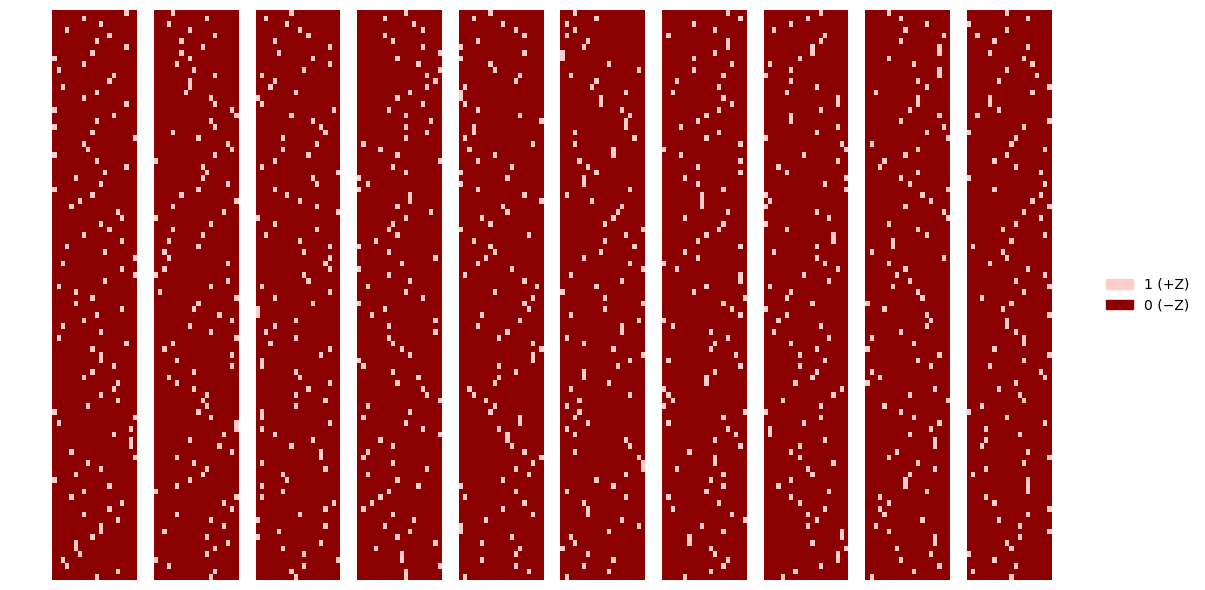

In [26]:
cols = 10
rows = data_subset.shape[0] // cols
panel_width = data_subset.shape[1]
spacer = 4
left_padding = 10
right_padding = 10

canvas_width = (left_padding + cols * panel_width + (cols - 1) * spacer + right_padding)

bright_red = "darkred"
dark_red = "#ffcccc"
flip_red_cmap = ListedColormap([bright_red, dark_red])
flip_red_cmap.set_bad("white")

canvas = np.full((rows, canvas_width), np.nan, dtype=np.float32)
for i in range(cols):
    start_x = left_padding + i * (panel_width + spacer)
    block = data_subset[i * rows:(i + 1) * rows, :]
    canvas[:, start_x:start_x + panel_width] = block

plt.figure(figsize=(12, 6))
img = plt.imshow(canvas, cmap=flip_red_cmap, interpolation='nearest', aspect='auto')
plt.axis('off')

dark_patch = mpatches.Patch(color=dark_red, label="1 (+Z)")
bright_patch = mpatches.Patch(color=bright_red, label="0 (−Z)")
plt.legend(
    handles=[dark_patch, bright_patch],
    loc="center right",
    bbox_to_anchor=(1.1, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [27]:
class DataLoader:
    def __init__(self, dataset, batch_size=128, shuffle=True, drop_last=False):
        self.x         = dataset
        self.bs        = batch_size
        self.shuffle   = shuffle
        self.drop_last = drop_last

        n_samples = len(self.x)
        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, n_samples, batch_size)
            if not drop_last or i + batch_size <= n_samples
        ]

    def __iter__(self):
        order = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(order)
        for s, e in self.idx_slices:
            yield self.x[order[s:e]]

    def __len__(self):
        return len(self.idx_slices)

In [28]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, rng: PRNGKey) -> (jnp.ndarray, jnp.ndarray):
        # in flax, __call__ is the main computation to be differentiated.

        # initialize parameters in @nn.compact style:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        params = {"W": W, "b": b, "c": c}

        # gibbs sampling only refines the fantasy particles, we are actually not interested in the gradients
        v_k, key = self._gibbs_sample(params, v_persistent, rng, k=self.k)
        v_k = jax.lax.stop_gradient(v_k)

        # we are interested in the gradients of the free energy w.r.t. the parameters
        free_energy_data  = self._free_energy(params, data_batch)
        free_energy_model = self._free_energy(params, v_k)

        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        # since this is a pcd loss function, we also return the updated fantasy particles. and we also pass through the key
        # since JAX’s tree utilities flatten nested tuples we need to wrap the auxiliary variables in a container
        aux_vars = {"v_persistent": v_k, "key": key}

        return pcd_loss, aux_vars

    @staticmethod
    def _free_energy(params, v):
        W, b, c = params["W"], params["b"], params["c"]

        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, params, T=1.0):
        v, key = state
        W, b, c = params["W"], params["b"], params["c"]

        # splitting generates different random numbers for each step, one of them is passed on
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(params, v_init, rng, k=1, T=1.0):
        # the fori_loop enables JIT compilation of loops. It basically unrolls the loop over the fixed length k.

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    @staticmethod
    def _annealing_step(i, state, params, T_schedule):
        v, rng = state
        T = T_schedule[i]
        # Perform one Gibbs step using the current temperature T.
        # Note: _gibbs_sample already handles k=1 and T
        v_next, rng_next = RBM._gibbs_sample(params, v, rng, k=1, T=T)
        return (v_next, rng_next)

    # the nowrap attribute basically tells JAX to not do the magic wrapping, which injects the params argument
    @nn.nowrap
    def generate(self, params: dict, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:

        # get the initial state and perform initial key splitting
        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        init_state = (v, rng)

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T_schedule[i])

        # the fori_loop is still required, since this function will also be JIT-compiled
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, init_state)
        return v_final

In [29]:
class RBMTrainState(train_state.TrainState):
    """
    A value object bundling parameters and optimizer state for training.
    It has a few pre-defined fields to be used in the training loop.
    Since it is immutable, the training function needs to return a new instance after each update step.
    """
    pass


@functools.partial(jax.jit)
def train_step(state: RBMTrainState, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, key: PRNGKey):

    # only the 'params' argument remains a variable to be differentiated
    pcd_loss_fn = lambda params: state.apply_fn({'params': params}, data_batch, v_persistent, key)

    # since our pc_loss_fn also returns the updated fantasy particles, we need to use has_aux=True
    value_and_grad_fn = jax.value_and_grad(pcd_loss_fn, has_aux=True)
    (pcd_loss, aux_vars), pdc_loss_grads = value_and_grad_fn(state.params)

    # apply the gradients to the state, this actually updates the optimizer state
    new_state = state.apply_gradients(grads=pdc_loss_grads)
    v_persistent = aux_vars["v_persistent"]
    key = aux_vars["key"]

    return new_state, pcd_loss, v_persistent, key


def train_rbm(state: RBMTrainState, train_loader, num_epochs: int, rng: PRNGKey, pcd_reset: int = 5, scheduler=None):
    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, data in enumerate(train_loader):

            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=data.shape).astype(jnp.float32)

            state, loss, v_persistent, rng = train_step(state, data, v_persistent, rng)
            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng

In [34]:
# ACTUAL TRAINING
batch_size    = 128
visible_units = 20
hidden_units  = 20
k_steps       = 1
lr            = 1e-2
num_epochs    = 500
pcd_reset     = 75        # reset persistent chain every N batches
weight_decay  = 1e-5      # if needed; see optax.add_decayed_weights
lr_decay      = 0.95      # not used explicitly here


# start of our random key-chain, it will be updated by regular splits (typically at each bernoulli sampling)
rng = PRNGKey(0)

# instantiate the optimizer and the RBM
train_loader = DataLoader(data_subset, batch_size=batch_size, shuffle=True)

optimizer = optax.adam(learning_rate=lr)
rbm = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)

# initialize RBM parameters and create the training state
dummy_batch = data_subset[:batch_size]
rng, subkey = jax.random.split(rng)
v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=dummy_batch.shape).astype(jnp.float32)
params = rbm.init(rng, dummy_batch, v_persistent, rng)['params']

#p = 1/20
#init_b = np.full((20,), np.log(p/(1-p)), dtype=np.float32)
#params['b'] = jnp.array(init_b)


state = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=optimizer)

state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng)

Epoch [1/500] - Free Energy Loss: -2.3366
Epoch [2/500] - Free Energy Loss: -5.0447
Epoch [3/500] - Free Energy Loss: -5.6466
Epoch [4/500] - Free Energy Loss: -6.0099
Epoch [5/500] - Free Energy Loss: -5.3390
Epoch [6/500] - Free Energy Loss: -4.6173
Epoch [7/500] - Free Energy Loss: -4.3712
Epoch [8/500] - Free Energy Loss: -4.0400
Epoch [9/500] - Free Energy Loss: -4.2866
Epoch [10/500] - Free Energy Loss: -3.9871
Epoch [11/500] - Free Energy Loss: -2.8897
Epoch [12/500] - Free Energy Loss: -3.2611
Epoch [13/500] - Free Energy Loss: -2.9659
Epoch [14/500] - Free Energy Loss: -2.2184
Epoch [15/500] - Free Energy Loss: -1.9539
Epoch [16/500] - Free Energy Loss: -1.2016
Epoch [17/500] - Free Energy Loss: -1.4248
Epoch [18/500] - Free Energy Loss: -1.0422
Epoch [19/500] - Free Energy Loss: -0.9571
Epoch [20/500] - Free Energy Loss: -0.3361
Epoch [21/500] - Free Energy Loss: -0.4499
Epoch [22/500] - Free Energy Loss: -0.3299
Epoch [23/500] - Free Energy Loss: -0.5093
Epoch [24/500] - Fre

Text(0, 0.5, 'Free Energy Loss')

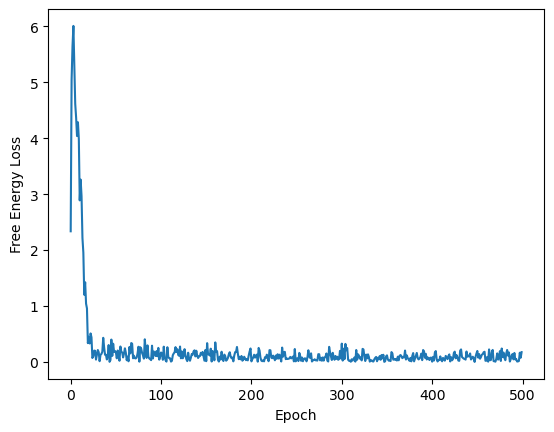

In [35]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [38]:
def get_cosine_schedule(T_high, T_low, n_steps):
    steps = jnp.arange(n_steps, dtype=jnp.float32)
    cos = 0.5 * (1 + jnp.cos(jnp.pi * steps / (n_steps - 1)))
    return T_low + (T_high - T_low) * cos


cosine_schedule = get_cosine_schedule(4.0, 0.4, 200)
samples = rbm.generate(params = state.params, n_samples=1000, T_schedule=cosine_schedule, rng=rng)
samples

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
rel_freq = samples.mean(axis=0)
rel_freq

Array([0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.001], dtype=float32)

In [42]:
samples = rbm.generate(state.params,
                       n_samples=10_000,
                       T_schedule=jnp.ones(200), # 200 Gibbs steps, T=1
                       rng=rng)
rel_freq = samples.mean(0)
rel_freq

Array([0.0662, 0.0545, 0.0358, 0.0285, 0.036 , 0.0433, 0.0448, 0.0303,
       0.0633, 0.0599, 0.0492, 0.0405, 0.0561, 0.0589, 0.0641, 0.0496,
       0.0407, 0.066 , 0.0312, 0.0546], dtype=float32)

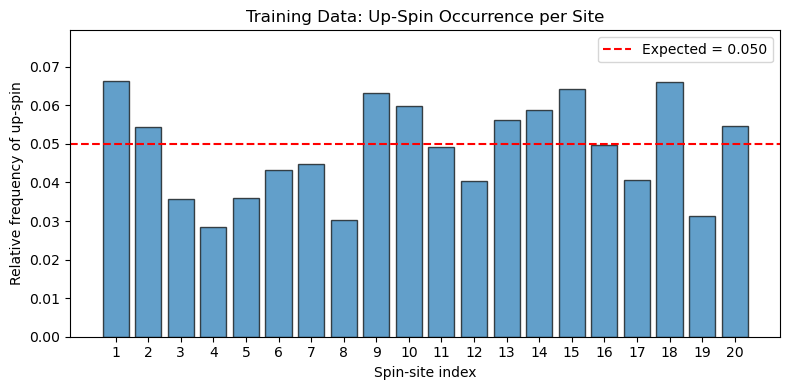

In [43]:
fig, ax = plt.subplots(figsize=(8,4))
sites = np.arange(1, visible_units+1)
ax.bar(sites, rel_freq, width=0.8, edgecolor='black', alpha=0.7)
ax.axhline(1/visible_units, color='red', linestyle='--', label=f'Expected = {1/visible_units:.3f}')

ax.set_xlabel('Spin‐site index')
ax.set_ylabel('Relative frequency of up‐spin')
ax.set_title('Training Data: Up‐Spin Occurrence per Site')
ax.set_xticks(sites)
ax.set_ylim(0, rel_freq.max()*1.2)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()